# Figure 4 Analysis: Phenotype Complexity vs Performance

This notebook analyzes how ELDER and ontology-only approaches perform across different phenotype complexity levels.

## Setup

First, let's import the required libraries and set up our analysis environment.

In [1]:
import json
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import duckdb

DATA_DIR = Path("../data")
RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(exist_ok=True)

DEFAULT_DATASET = "normalized_phenopackets_07"
DB_PATH = DATA_DIR / "Best_Match_Cosine_all_combined_Elder_vs_Exomiser.db"

print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Default dataset: {DEFAULT_DATASET}")

Data directory: ../data
Results directory: ../results
Default dataset: normalized_phenopackets_07


## Download Required Database

First, let's download the required database from Zenodo if it doesn't exist:

In [2]:
import urllib.request
import os
from pathlib import Path

ZENODO_URL = "https://zenodo.org/records/16944913/files/Best_Match_Cosine_all_combined_Elder_vs_Exomiser.db"
DB_FILENAME = "Best_Match_Cosine_all_combined_Elder_vs_Exomiser.db"
DB_PATH = DATA_DIR / DB_FILENAME

def download_with_progress(url, filepath):
    """Download file with progress indicator."""
    def progress_hook(block_num, block_size, total_size):
        downloaded = block_num * block_size
        if total_size > 0:
            percent = min(100, (downloaded * 100) // total_size)
            mb_downloaded = downloaded / (1024 * 1024)
            mb_total = total_size / (1024 * 1024)
            print(f"\rDownloading: {percent:3d}% ({mb_downloaded:.1f}/{mb_total:.1f} MB)", end="", flush=True)
    
    urllib.request.urlretrieve(url, filepath, progress_hook)
    print()

if not DB_PATH.exists():
    print(f"Database not found at: {DB_PATH}")
    print(f"Downloading from Zenodo...")
    print(f"URL: {ZENODO_URL}")
    
    DATA_DIR.mkdir(exist_ok=True)
    
    try:
        download_with_progress(ZENODO_URL, DB_PATH)
        print(f"Database downloaded successfully!")
        print(f"Saved to: {DB_PATH}")
        print(f"File size: {DB_PATH.stat().st_size / (1024*1024):.1f} MB")
        
    except Exception as e:
        print(f"Download failed: {e}")
        print(f"")
        print(f"Manual download instructions:")
        print(f"   1. Visit: https://zenodo.org/records/16944913")
        print(f"   2. Download: {DB_FILENAME}")
        print(f"   3. Place it in: {DATA_DIR}/")
        print(f"")
        print(f"The analysis cannot continue without the database.")
        
else:
    print(f"Database found at: {DB_PATH}")
    print(f"File size: {DB_PATH.stat().st_size / (1024*1024):.1f} MB")

Database found at: ../data/Best_Match_Cosine_all_combined_Elder_vs_Exomiser.db
File size: 9.5 MB


## Check Available Datasets

Let's see what normalized datasets are available:

In [3]:
available_datasets = []
for item in DATA_DIR.iterdir():
    if item.is_dir() and item.name.startswith("normalized_phenopackets"):
        file_count = len(list(item.glob("*.json")))
        available_datasets.append((item.name, file_count))

print("Available normalized datasets:")
for dataset, count in sorted(available_datasets):
    marker = " (paper)" if dataset == DEFAULT_DATASET else ""
    print(f"  {dataset}: {count} files{marker}")


Available normalized datasets:
  normalized_phenopackets_01: 2053 files
  normalized_phenopackets_02: 2053 files
  normalized_phenopackets_03: 2053 files
  normalized_phenopackets_04: 2053 files
  normalized_phenopackets_05: 2053 files
  normalized_phenopackets_06: 2053 files
  normalized_phenopackets_07: 2053 files (paper)
  normalized_phenopackets_08: 2053 files
  normalized_phenopackets_09: 2053 files
  normalized_phenopackets_10: 2053 files


## Define Analysis Functions

Let's define the core analysis functions:

In [4]:
def query_performance_data(bins, db_path):
    """
    Query the database for ELDER and Exomiser performance data.
    
    Returns:
        - elder_per_case: Dictionary mapping filenames to ELDER top-1 accuracy
        - exomiser_per_case: Dictionary mapping filenames to Exomiser top-1 accuracy
    """
    elder_per_case = {}
    exomiser_per_case = {}
    
    print(f"\nQuerying database: {db_path}")
    
    if not db_path.exists():
        print(f"Error: Database not found at {db_path}")
        print("Please download the database from the Zenodo link provided in README.md")
        return elder_per_case, exomiser_per_case
    
    conn = duckdb.connect(str(db_path))
    
    all_files = []
    for bin_files in bins.values():
        all_files.extend(bin_files)
    
    print(f"Querying performance data for {len(all_files)} files...")
    
    successful_queries = 0
    
    for filename in all_files:
        query = """
        SELECT Exomiser, cosBMA_ELDER_large3
        FROM Exomiser_vs_cosBMA_ELDER_large3_disease_rank_comparison
        WHERE phenopacket = ?
        """
        
        try:
            result = conn.execute(query, [filename]).fetchone()
            if result:
                exomiser_rank, elder_rank = result
                exomiser_top1 = 1 if exomiser_rank == 1 else 0
                elder_top1 = 1 if elder_rank == 1 else 0
                
                exomiser_per_case[filename] = exomiser_top1
                elder_per_case[filename] = elder_top1
                successful_queries += 1
            else:
                exomiser_per_case[filename] = 0
                elder_per_case[filename] = 0
        
        except Exception as e:
            print(f"Database query error for {filename}: {e}")
            exomiser_per_case[filename] = 0
            elder_per_case[filename] = 0
    
    conn.close()
    
    print(f"Successfully queried {successful_queries}/{len(all_files)} files")
    
    return elder_per_case, exomiser_per_case

In [5]:
def load_dataset_and_bin_by_complexity(dataset_path):
    """
    Load phenopackets and assign them to complexity bins.
    
    Returns:
        - bins: Dictionary mapping bin names to lists of filenames
        - file_to_disease: Dictionary mapping filenames to disease IDs
    """
    # bins = {
    #     "1-5": [],
    #     "10-15": [],
    #     "15-20": [],
    #     "20-25": [],
    #     "25-30": [],
    #     "30-35": [],
    #     "35-40": [],
    #     "40-45": [],
    #     "45+": [],
    # }
    bins = {
        "1-10": [],
        "10-20": [],
        "20-30": [],
        "30-40": [],
        "40+": [],
    }
    
    file_to_disease = {}
    phenotype_counts = []
    
    print(f"Loading dataset from: {dataset_path}")
    
    for json_file in dataset_path.glob("*.json"):
        try:
            with open(json_file, 'r') as f:
                phenopacket = json.load(f)
            
            if 'diseases' in phenopacket and phenopacket['diseases']:
                disease_id = phenopacket['diseases'][0]['term']['id']
                file_to_disease[json_file.name] = disease_id
            
            phenotype_count = 0
            if 'phenotypicFeatures' in phenopacket:
                phenotype_count = len(phenopacket['phenotypicFeatures'])
            
            phenotype_counts.append(phenotype_count)
            
            filename = json_file.name
            if 1 <= phenotype_count <= 10:
                bins["1-10"].append(filename)
            elif 10 <= phenotype_count <= 20:
                bins["10-20"].append(filename)
            elif 21 <= phenotype_count <= 30:
                bins["20-30"].append(filename)
            elif 31 <= phenotype_count <= 40:
                bins["30-40"].append(filename)
            elif phenotype_count > 40:
                bins["40+"].append(filename)
        
        except Exception as e:
            print(f"Error processing {json_file}: {e}")
            continue
    
    total_binned = sum(len(files) for files in bins.values())
    print(f"\nDataset summary:")
    print(f"  Total files processed: {len(phenotype_counts)}")
    print(f"  Files assigned to bins: {total_binned}")
    print(f"  Average phenotypes per case: {np.mean(phenotype_counts):.1f}")
    
    print(f"\nBin distribution:")
    for bin_name, files in bins.items():
        print(f"  {bin_name}: {len(files)} files")
    
    return bins, file_to_disease

In [6]:
def calculate_bin_accuracies(bins, elder_per_case, exomiser_per_case):
    """
    Calculate average top-1 accuracy for each phenotype complexity bin.
    
    Returns:
        - elder_bin_accuracies: Dictionary mapping bin names to ELDER accuracies
        - exomiser_bin_accuracies: Dictionary mapping bin names to Exomiser accuracies
    """
    elder_bin_accuracies = {}
    exomiser_bin_accuracies = {}
    
    print(f"\nCalculating bin-wise accuracies:")
    
    for bin_name, files in bins.items():
        if files:
            elder_accuracies = [elder_per_case.get(f, 0) for f in files]
            exomiser_accuracies = [exomiser_per_case.get(f, 0) for f in files]
            
            elder_bin_accuracies[bin_name] = sum(elder_accuracies) / len(elder_accuracies)
            exomiser_bin_accuracies[bin_name] = sum(exomiser_accuracies) / len(exomiser_accuracies)
            
            print(f"  Bin {bin_name}: {len(files)} files")
            print(f"    ELDER: {elder_bin_accuracies[bin_name]:.3f}")
            print(f"    Ontology-only: {exomiser_bin_accuracies[bin_name]:.3f}")
            print(f"    Difference: {elder_bin_accuracies[bin_name] - exomiser_bin_accuracies[bin_name]:+.3f}")
        else:
            elder_bin_accuracies[bin_name] = 0
            exomiser_bin_accuracies[bin_name] = 0
    
    return elder_bin_accuracies, exomiser_bin_accuracies

In [7]:
def create_figure(elder_bin_accuracies, exomiser_bin_accuracies, dataset_name, save_plots=True):
    """
    Create the comparative bar chart (Figure 4).
    
    Parameters:
        - elder_bin_accuracies: ELDER accuracies by bin
        - exomiser_bin_accuracies: Exomiser accuracies by bin
        - dataset_name: Name of dataset being analyzed
        - save_plots: Whether to save the plots to files
    """
    plt.figure(figsize=(14, 8))
    
    bin_names = list(elder_bin_accuracies.keys())
    elder_accuracies = list(elder_bin_accuracies.values())
    exomiser_accuracies = list(exomiser_bin_accuracies.values())
    
    x = np.arange(len(bin_names))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, exomiser_accuracies, width, label='Ontology-only', 
                   color='lightcoral', edgecolor='black', alpha=0.7)
    bars2 = plt.bar(x + width/2, elder_accuracies, width, label='ELDER', 
                   color='skyblue', edgecolor='black', alpha=0.7)
    
    plt.xlabel('Phenotype Count Bins', fontsize=12)
    plt.ylabel('Average Top-1 Accuracy', fontsize=12)
    plt.ylim(0, 1.0)
    plt.xticks(x, bin_names)
    plt.legend(fontsize=11)
    
    for bar, accuracy in zip(bars1, exomiser_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{accuracy:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    for bar, accuracy in zip(bars2, elder_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{accuracy:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    plt.figtext(0.5, 0.02, f'Dataset: {dataset_name}', ha='center', fontsize=10, style='italic')
    
    if save_plots:
        svg_path = RESULTS_DIR / 'figure_4_performance_as_func_of_nr_of_pheno_p_case.svg'
        png_path = RESULTS_DIR / 'figure_4_performance_as_func_of_nr_of_pheno_p_case.png'
        
        plt.savefig(svg_path, bbox_inches='tight')
        plt.savefig(png_path, dpi=300, bbox_inches='tight')
        
        print(f"\nPlots saved:")
        print(f"  SVG: {svg_path}")
        print(f"  PNG: {png_path}")
    
    plt.show()
    
    elder_overall = np.mean(elder_accuracies)
    exomiser_overall = np.mean(exomiser_accuracies)
    difference = elder_overall - exomiser_overall
    
    print(f"\nOverall Performance Summary:")
    print(f"  ELDER average: {elder_overall:.3f}")
    print(f"  Ontology-only average: {exomiser_overall:.3f}")
    print(f"  Difference: {difference:+.3f} ({'ELDER better' if difference > 0 else 'Ontology-only better'})")

## Run the Analysis

Now let's run the complete analysis pipeline:

In [8]:
DATASET_TO_ANALYZE = DEFAULT_DATASET
dataset_path = DATA_DIR / DATASET_TO_ANALYZE

print(f"Running Figure 4 Analysis")
print(f"Dataset: {DATASET_TO_ANALYZE}")
print("=" * 50)

bins, file_to_disease = load_dataset_and_bin_by_complexity(dataset_path)

Running Figure 4 Analysis
Dataset: normalized_phenopackets_07
Loading dataset from: ../data/normalized_phenopackets_07

Dataset summary:
  Total files processed: 2053
  Files assigned to bins: 2053
  Average phenotypes per case: 16.5

Bin distribution:
  1-10: 795 files
  10-20: 743 files
  20-30: 305 files
  30-40: 118 files
  40+: 92 files


In [9]:
elder_per_case, exomiser_per_case = query_performance_data(bins, DB_PATH)


Querying database: ../data/Best_Match_Cosine_all_combined_Elder_vs_Exomiser.db
Querying performance data for 2053 files...
Successfully queried 2053/2053 files



Calculating bin-wise accuracies:
  Bin 1-10: 795 files
    ELDER: 0.387
    Ontology-only: 0.333
    Difference: +0.054
  Bin 10-20: 743 files
    ELDER: 0.649
    Ontology-only: 0.540
    Difference: +0.109
  Bin 20-30: 305 files
    ELDER: 0.725
    Ontology-only: 0.646
    Difference: +0.079
  Bin 30-40: 118 files
    ELDER: 0.661
    Ontology-only: 0.415
    Difference: +0.246
  Bin 40+: 92 files
    ELDER: 0.598
    Ontology-only: 0.435
    Difference: +0.163

Plots saved:
  SVG: ../results/figure_4_performance_as_func_of_nr_of_pheno_p_case.svg
  PNG: ../results/figure_4_performance_as_func_of_nr_of_pheno_p_case.png


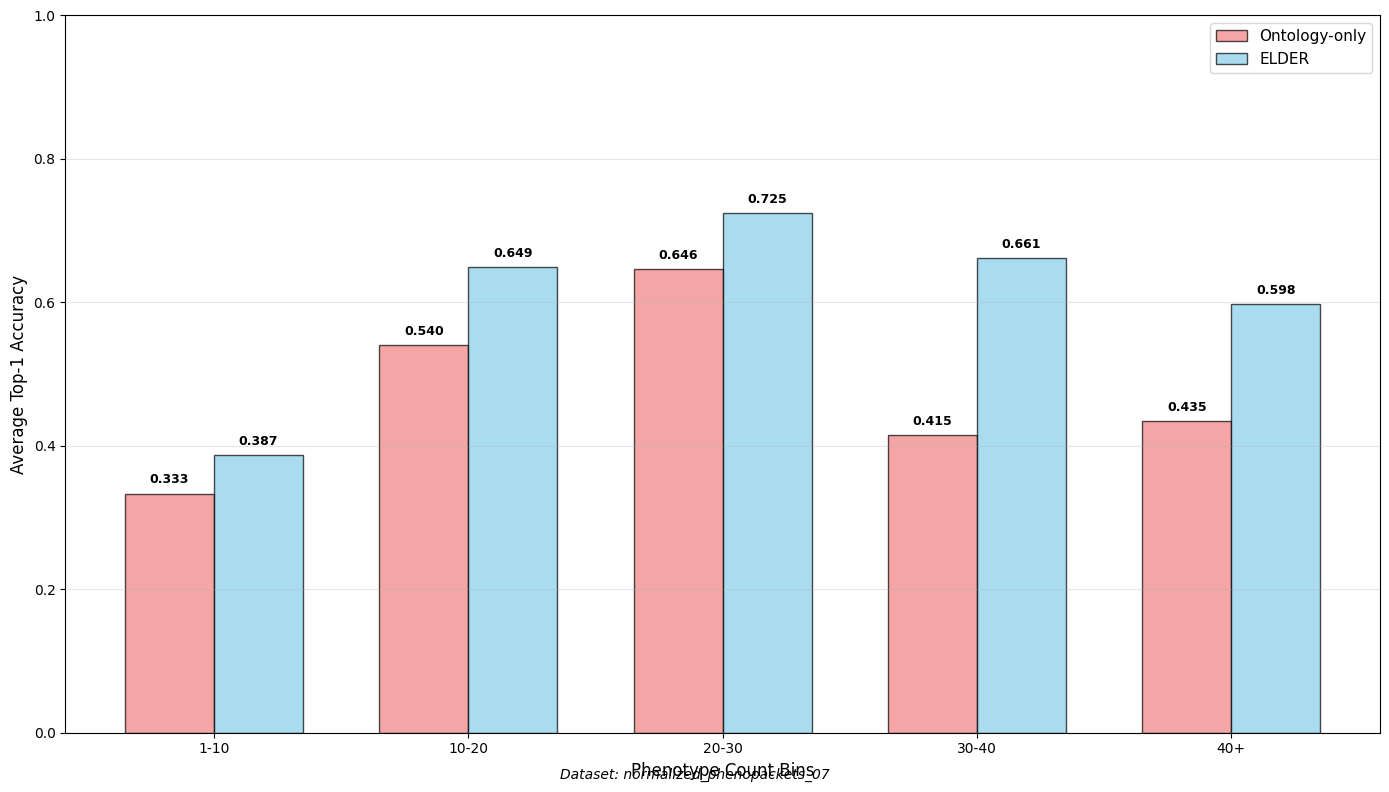


Overall Performance Summary:
  ELDER average: 0.604
  Ontology-only average: 0.474
  Difference: +0.130 (ELDER better)


In [10]:
elder_bin_accuracies, exomiser_bin_accuracies = calculate_bin_accuracies(
    bins, elder_per_case, exomiser_per_case
)
create_figure(elder_bin_accuracies, exomiser_bin_accuracies, DATASET_TO_ANALYZE, save_plots=True)


## Compare Different Datasets (Optional)

You can run this cell to quickly compare how different datasets perform:

In [11]:
COMPARE_DATASETS = True

if COMPARE_DATASETS and len(available_datasets) > 1:
    print("Comparing multiple datasets...\n")

    dataset_comparisons = []

    for dataset_name, _ in available_datasets[:3]:
        print(f"Analyzing {dataset_name}...")

        dataset_path = DATA_DIR / dataset_name
        bins_temp, _ = load_dataset_and_bin_by_complexity(dataset_path)
        elder_temp, exomiser_temp = query_performance_data(bins_temp, DB_PATH)
        elder_acc_temp, exomiser_acc_temp = calculate_bin_accuracies(
            bins_temp, elder_temp, exomiser_temp
        )

        elder_overall = np.mean(list(elder_acc_temp.values()))
        exomiser_overall = np.mean(list(exomiser_acc_temp.values()))
        difference = elder_overall - exomiser_overall

        dataset_comparisons.append({
            'dataset': dataset_name,
            'elder_accuracy': elder_overall,
            'exomiser_accuracy': exomiser_overall,
            'difference': difference
        })

        print(f"  ELDER: {elder_overall:.3f}, Ontology-only: {exomiser_overall:.3f}, Diff: {difference:+.3f}\n")

    dataset_comparisons.sort(key=lambda x: x['difference'], reverse=True)

    print("Dataset Comparison Summary:")
    for i, result in enumerate(dataset_comparisons, 1):
        marker = " (recommended)" if result['dataset'] == DEFAULT_DATASET else ""
        print(f"{i}. {result['dataset']}: ELDER advantage = {result['difference']:+.3f}{marker}")
else:
    print("Skipping dataset comparison...")

Comparing multiple datasets...

Analyzing normalized_phenopackets_03...
Loading dataset from: ../data/normalized_phenopackets_03

Dataset summary:
  Total files processed: 2053
  Files assigned to bins: 2053
  Average phenotypes per case: 16.4

Bin distribution:
  1-10: 806 files
  10-20: 737 files
  20-30: 311 files
  30-40: 111 files
  40+: 88 files

Querying database: ../data/Best_Match_Cosine_all_combined_Elder_vs_Exomiser.db
Querying performance data for 2053 files...
Successfully queried 2053/2053 files

Calculating bin-wise accuracies:
  Bin 1-10: 806 files
    ELDER: 0.375
    Ontology-only: 0.333
    Difference: +0.042
  Bin 10-20: 737 files
    ELDER: 0.649
    Ontology-only: 0.555
    Difference: +0.094
  Bin 20-30: 311 files
    ELDER: 0.698
    Ontology-only: 0.630
    Difference: +0.068
  Bin 30-40: 111 files
    ELDER: 0.694
    Ontology-only: 0.414
    Difference: +0.279
  Bin 40+: 88 files
    ELDER: 0.591
    Ontology-only: 0.432
    Difference: +0.159
  ELDER: 0.601,